# GPT2 decoding, about generation
## 0. Import packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
import pandas as pd

device = "cpu"

## 1. Summary: Decoding & Autoregressive Language Models (GPT-style)

- LMHead → Text
  - The LM head outputs a probability distribution over the vocabulary at each step.
  - Text generation converts these probabilities into tokens iteratively, trading more compute for control over quality and diversity.
- Decoding Strategies
  - **Greedy Search**: take the top-1 token each step (fast, prone to local optima).
  - **Beam Search**: maintain multiple candidate sequences (more global, less diverse).
  - Sampling: draw from the distribution to increase diversity.
    - Top-k: sample from the k highest-probability tokens.
    - Nucleus (Top-p): sample from the smallest set whose cumulative probability ≥ p.
- Use Cases
  - Open-ended text generation
  - Seq2Seq tasks (e.g., machine translation)
  - Image captioning (image-to-text)
- Autoregressive (Causal) Language Models
  - Given input x and output sequence y = (y₁,…,y_T), the chain rule yields:
      $$P(y | x) = ∏_{i=1}^{T} P(y_i | y_{<i}, x)$$ Sentence probability = probability of the first word in the first step × probability of the second word in the second step × …
      $$log P(y | x) = Σ_{i=1}^{T} log P(y_i | y_{<i}, x)$$
  - Left-to-right, unidirectional (contrast with BERT’s bidirectional modeling).
  - loss is usually the **negative log likelihood (NLL)**.
- One-Step Decoding as Vocabulary Classification
  - For step t with logits z_t (z_t = logits):
      $$P(y_t = w_j | y_{<t}, x) = softmax(z_t)_j$$
      $$ŷ = argmax_y P(y | x)$$

## 2. decoding
- greedy search decoding
- beam search decoding

In [2]:
from transformers import AutoModelForCausalLM, AutoModel # Add a LMHead in GPT2 -> Linear(in_features=768, out_features=50257, bias=False)

model_name = 'gpt2'

model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = 'Long long ago'

model_inputs = tokenizer(text, return_tensors='pt')
model_inputs

{'input_ids': tensor([[14617,   890,  2084]]), 'attention_mask': tensor([[1, 1, 1]])}

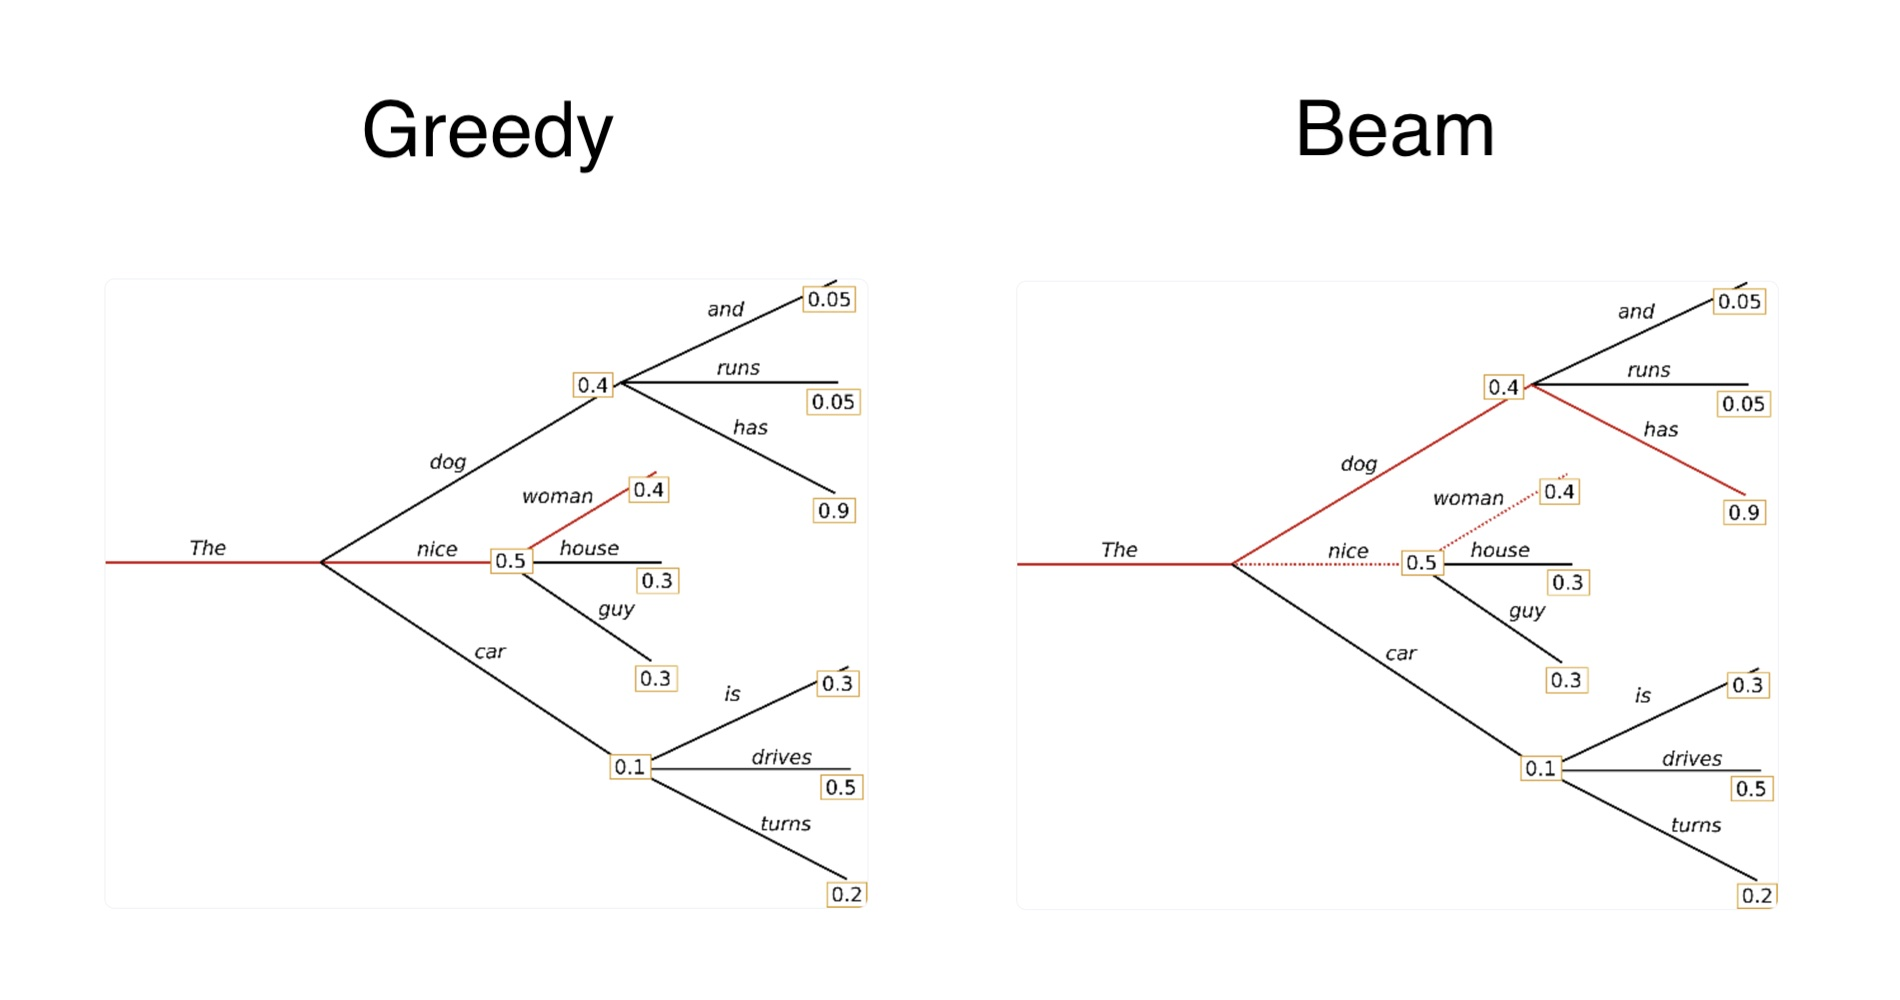

In [3]:
Image(filename='Images/greedy-beam.png')

### 2.1 greedy search

In [4]:
def greedy_search(model, input_ids, max_steps=8, max_choices=4):
    """
    Simple greedy search decoder for GPT-style models.

    Args:
        model: a causal LM (GPT2LMHeadModel)
        input_ids: tensor of shape [1, seq_len], the prompt
        max_steps: number of tokens to generate
        max_choices: how many top candidates to display each step

    Returns:
        iterations: list of dicts with prompt and top-k choices per step
    """
    iterations = []
    generated = input_ids.clone()

    with torch.no_grad():
        for _ in range(max_steps):
            step_info = {}
            step_info['input'] = tokenizer.decode(generated[0])

            # Forward pass → logits for each vocab token
            logits = model(generated).logits
            last_token_logits = logits[0, -1, :]  # [batch_size, seq_len, vocab_size] -> [vocab_size]
            probs = torch.softmax(last_token_logits, dim=-1)  # -> [p₁, p₂, …, p_V], sum = 1.

            # argsort sorts the vocabulary ids by probability from highest to lowest, generating a sorted index.
            sorted_ids = torch.argsort(probs, descending=True) 

            # Record top-k candidate tokens
            for i in range(max_choices):
                tok_id = sorted_ids[i].item()
                tok_prob = probs[tok_id].item()
                tok_str = tokenizer.decode([tok_id])
                step_info[f'choice {i+1}'] = f"{tok_str} ({tok_prob*100:.2f}%)"

            # Greedy pick: append the top-1 token
            next_id = sorted_ids[0].unsqueeze(0).unsqueeze(0)  # shape [1,1]
            generated = torch.cat([generated, next_id], dim=-1)

            iterations.append(step_info)

    return iterations

In [5]:
input_ids = model_inputs['input_ids']

pd.DataFrame(greedy_search(model, input_ids, ))

,input,choice 1,choice 2,choice 3,choice 4
0,Long long ago,", (61.96%)",the (4.78%),I (2.95%),there (2.31%)
1,"Long long ago,",the (12.06%),when (7.10%),I (4.69%),there (4.06%)
2,"Long long ago, the",world (2.06%),first (0.97%),people (0.92%),only (0.89%)
3,"Long long ago, the world",was (30.42%),'s (11.25%),had (7.60%),of (6.25%)
4,"Long long ago, the world was",a (10.45%),ruled (6.62%),divided (5.66%),filled (3.36%)
5,"Long long ago, the world was a",land (7.05%),place (5.52%),vast (2.26%),peaceful (1.94%)
6,"Long long ago, the world was a land",of (81.59%),where (5.59%),that (0.87%),full (0.83%)
7,"Long long ago, the world was a land of",great (1.85%),the (1.49%),chaos (1.36%),giants (1.30%)


#### 2.1.1 model.generate()
- The default is **greedy search**, num_beams -> **beam search**
- do_sample = False
- max_length: total length -> prompt + generation
- max_new_tokens: length of generation

In [6]:
input_ids = tokenizer(text, return_tensors='pt').input_ids
output = model.generate(input_ids, max_new_tokens=8, do_sample=False)
tokenizer.decode(output[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'Long long ago, the world was a land of great'

### 2.2 beam search
#### 2.2.1 model.generate()
- num_beams = num_beams -> **beam search**
- do_sample = False
- max_length: total length -> prompt + generation
- max_new_tokens: length of generation
- no_repeat_ngram_size = 2
    - tracks which n-grams have been seen and sets the next token probability to zero
    - if it would produce a previously seen n-gram;

In [21]:
def log_probs_from_logits(logits, labels): 
    """
    Get log-probabilities of the true labels from model logits.
    logits ---predict---> labels
    
    Args:
        logits: Tensor [B, T, V] - raw scores from the model
        labels: Tensor [B, T]    - true token IDs

    Returns:
        log_probs: Tensor [B, T] - log-probabilities assigned to each true token
    """
    logp = F.log_softmax(logits, dim=-1) # [B, T, V]
    logp_label = torch.gather(logp, 2, labels.unsqueeze(-1)) # pick probs at label positions
    return logp_label.squeeze(-1) # [B, T]


def sequence_logprob(model, labels, prompt_len=0):
    """
    Compute total log-probability of a sequence under the model.
    
    Args:
        model: causal LM 
        labels: Tensor [B, T] - tokenized input (prompt + target)
        prompt_len: int
    
    Returns:
        seq_log_prob: float - summed log-probability of the sequence
    """
    with torch.no_grad():
        output = model(labels) # forward pass
        # Use the first position of logits -> corresponds to the second word of label
        # logits -> [:, t, :], the word of t+1
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, prompt_len:]) # sum over target tokens only
    return seq_log_prob.item()

### 2.3 Compare
- greedy search
- beam search with repeat ngram
- beam search with no repeat ngram

The smaller logp, the better output.

In [20]:
output_greedy = model.generate(input_ids, max_length=128, do_sample=False)
logp = sequence_logprob(model, output_greedy, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(logp)
print("----------")

output_beam = model.generate(input_ids, max_length=128, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(logp)
print("----------")

output_beam = model.generate(input_ids, max_length=128, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, prompt_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(logp)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Long long ago, the world was a land of great wealth and great beauty. Now, it is a land of great poverty and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is a land of great wealth and great suffering. The world is
-61.81418991088867
----------


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Long long ago, when I was a child, I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I had a dream that I was going to become an astronaut. I
-48.145687103271484
----------
Long long ago, when I was a kid, I used to go to the movies with my dad, and he would say, "You know what, if you're going to do this, you've got to get out there and do it." And I did. And that's what I'm doing now.

And I've been doing it for a long time. I don't know how long it's been going on, but I do know that there's a lot of work to be done. It's just a matter of finding the right balance between what you want and what's bes